# __Etude de RL sur environnement Snake__

par Luke Goboyan, Charles  et Clément

In [1]:
import random as rd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import itertools
import seaborn as sns
import math

/home/clement/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## __Définition de l'environnement__

L'environnement défini est composé des règles du jeu Snake, ou l'acteur principal doit parcourir une grille limitée dans le but d'atteindre un score maximal de fruits tout en évitant d'entrer en collision avec le bord et son propre corps, allongé pour chaque fruit récolté.

Lors de l'évaluation de l'état, les valeurs observées sont: les coordonnées du fruit, les coordonnées de la tête de serpent, sa direction (up, left, right, down) et des indicateurs de danger immédiat.

Les actions prises sont définies comme:  
0 : UP (Haut),  
1 : DOWN (Bas),  
2 : LEFT (Gauche),  
3 : RIGHT (Droite).  
Il est impossible de prendre une direction "arrière" relative à la précedente, par exemple UP puis DOWN.

Les critères de récompense et pénalité sont définis comme il suit:  
+10 si un fruit est récolé  
-10 si c'est une collision, et dans ce cas la fin de partie  
-0.1 sinon, afin d'encourager une prise de chemins courts pour récolter les fruits, ainsi qu'éviter la stagnation de la partie par l'agent.

In [2]:
class SnakeEnv:
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    VISUAL_TILE_SIZE = 10

    class Direction:
        UP = (0, -1)
        DOWN = (0, 1)
        LEFT = (-1, 0)
        RIGHT = (1, 0)

    class RGB:
        RED = (255, 0, 0)
        GREEN = (0, 255, 0)
        BLUE = (0, 0, 255)
        BLACK = (0, 0, 0)
        WHITE = (255, 255, 255)

    @staticmethod
    def _give_random_position():
        return (rd.randint(0, SnakeEnv.GRID_WIDTH - 1),
                rd.randint(0, SnakeEnv.GRID_HEIGHT - 1))

    def __init__(self):
        self.snake = None
        self.snake_direction = None
        self.apple_position = None
        self.score = 0
        self.running = True
        # Initialize matplotlib figure and axes
        self.fig = None
        self.ax = None
        self.reset()

    def _is_dangerous(self, position):
        # Check for collision with walls
        if (
            position[0] < 0
            or position[0] >= self.GRID_WIDTH
            or position[1] < 0
            or position[1] >= self.GRID_HEIGHT
        ):
            return 1
        # Check for collision with snake body (excluding head if it's the next segment)
        # For checking danger, we consider the whole snake body. If the position is the current head, it's not a collision.
        if position in self.snake[1:]:
            return 1
        return 0

    def _get_observation(self):
        head_x, head_y = self.snake[0]
        apple_x, apple_y = self.apple_position

        # One-hot encoded direction
        direction_up = 1.0 if self.snake_direction == self.Direction.UP else 0.0
        direction_down = 1.0 if self.snake_direction == self.Direction.DOWN else 0.0
        direction_left = 1.0 if self.snake_direction == self.Direction.LEFT else 0.0
        direction_right = 1.0 if self.snake_direction == self.Direction.RIGHT else 0.0

        # Danger indicators
        # Straight ahead
        next_straight = (
            head_x + self.snake_direction[0],
            head_y + self.snake_direction[1],
        )
        danger_straight = self._is_dangerous(next_straight)

        # Relative left (rotate direction 90 degrees counter-clockwise: (dx, dy) -> (-dy, dx))
        dx, dy = self.snake_direction
        relative_left_direction = (-dy, dx)
        next_left = (
            head_x + relative_left_direction[0],
            head_y + relative_left_direction[1],
        )
        danger_left = self._is_dangerous(next_left)

        # Relative right (rotate direction 90 degrees clockwise: (dx, dy) -> (dy, -dx))
        relative_right_direction = (dy, -dx)
        next_right = (
            head_x + relative_right_direction[0],
            head_y + relative_right_direction[1],
        )
        danger_right = self._is_dangerous(next_right)

        # Observation array
        observation = [
            head_x,
            head_y,
            apple_x,
            apple_y,
            direction_up,
            direction_down,
            direction_left,
            direction_right,
            danger_straight,
            danger_left,
            danger_right,
        ]
        return np.array(observation, dtype=np.float32)

    def reset(self):
        self.snake = [self._give_random_position()]
        self.snake_direction = self.Direction.UP

        # Correct the initial direction check for matrix coordinates
        if self.snake[0][1] == self.GRID_HEIGHT - 1:
            self.snake_direction = self.Direction.DOWN

        self.apple_position = self._give_random_position()
        while self.apple_position in self.snake:
            self.apple_position = self._give_random_position()

        self.score = 0
        self.running = True

        # Return the initial observation
        return self._get_observation()

    def step(self, action):
        reward = 0
        done = False
        info = {}

        # 1. Map action to direction
        # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
        # Prevent immediate reversal
        if action == 0 and self.snake_direction != self.Direction.DOWN:
            self.snake_direction = self.Direction.UP
        elif action == 1 and self.snake_direction != self.Direction.UP:
            self.snake_direction = self.Direction.DOWN
        elif action == 2 and self.snake_direction != self.Direction.RIGHT:
            self.snake_direction = self.Direction.LEFT
        elif action == 3 and self.snake_direction != self.Direction.LEFT:
            self.snake_direction = self.Direction.RIGHT
        # If an invalid reversal action is given, direction remains unchanged

        # 2. Calculate new head position by directly adding the direction vector
        new_head = (
            self.snake[0][0] + self.snake_direction[0],
            self.snake[0][1] + self.snake_direction[1],
        )

        # 3. Check for game termination conditions
        # Out of bounds or Collision with self
        if self._is_dangerous(new_head) == 1:
            self.running = False
            reward = -10
            done = True
        else:
            # No collision or out-of-bounds
            self.snake.insert(0, new_head)

            # Check if apple eaten
            if new_head == self.apple_position:
                self.score += 1
                reward = 10
                # Generate new apple position
                new_apple = self._give_random_position()
                while new_apple in self.snake:
                    new_apple = self._give_random_position()
                self.apple_position = new_apple
            else:
                self.snake.pop()  # Remove tail if no apple eaten
                reward = -0.1  # Small penalty for surviving without eating

        # Define observation
        observation = self._get_observation()
        return observation, reward, done, info

    def render_matplotlib(self):
        if self.fig is None:
            # Figure size based on visual pixels
            # Setting dpi explicitly to control the rendered size
            self.fig, self.ax = plt.subplots(figsize=(self.GRID_WIDTH * self.VISUAL_TILE_SIZE / 100, self.GRID_HEIGHT * self.VISUAL_TILE_SIZE / 100), dpi=100)
            self.ax.set_title('Snake Game (Matplotlib)')
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            plt.show(block=False)

        self.ax.clear()
        # Set limits based on visual pixels
        self.ax.set_xlim(0, self.GRID_WIDTH * self.VISUAL_TILE_SIZE)
        self.ax.set_ylim(self.GRID_HEIGHT * self.VISUAL_TILE_SIZE, 0) # Invert y-axis

        # Draw snake segments
        snake_color = np.array(self.RGB.GREEN) / 255.0
        for segment in self.snake:
            # Convert matrix coordinates to pixel coordinates for rendering
            pixel_x = segment[0] * self.VISUAL_TILE_SIZE
            pixel_y = segment[1] * self.VISUAL_TILE_SIZE
            rect = patches.Rectangle((pixel_x, pixel_y), self.VISUAL_TILE_SIZE, self.VISUAL_TILE_SIZE, facecolor=snake_color)
            self.ax.add_patch(rect)

        # Draw apple
        apple_color = np.array(self.RGB.RED) / 255.0
        # Convert matrix coordinates to pixel coordinates for rendering
        pixel_apple_x = self.apple_position[0] * self.VISUAL_TILE_SIZE
        pixel_apple_y = self.apple_position[1] * self.VISUAL_TILE_SIZE
        apple_rect = patches.Rectangle((pixel_apple_x, pixel_apple_y), self.VISUAL_TILE_SIZE, self.VISUAL_TILE_SIZE, facecolor=apple_color)
        self.ax.add_patch(apple_rect)

        # Update title with score
        self.ax.set_title(f'Snake Game (Score: {self.score})')

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        display.clear_output(wait=True) # Clear previous output
        display.display(self.fig) # Display the updated figure

## __Mise en place des agents__

### Agent basé sur fonction de valeur: Q-Learning

Dans le cas de l'envireonnemnet Snake, l'agent de Q-Learning convertit l'évaluation de l'état en une forme discrète, puis forme une carte des actions à prendre selon les différentes combinaisons.

In [3]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay_rate=0.001, min_epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon

        # Define the discrete state space
        # State = (danger_straight, danger_left, danger_right, apple_x_dir, apple_y_dir)
        # danger_straight, danger_left, danger_right: 0 or 1
        # apple_x_dir: -1 (left), 0 (aligned), 1 (right)
        # apple_y_dir: -1 (up), 0 (aligned), 1 (down)
        self.state_space_size = (2, 2, 2, 3, 3) # 2^3 * 3 * 3 = 72 discrete states
        self.action_space_size = 4 # UP, DOWN, LEFT, RIGHT

        # Initialize Q-table with zeros
        self.q_table = np.zeros(self.state_space_size + (self.action_space_size,))

    def _get_discrete_state(self, observation):
        # observation: [head_x, head_y, apple_x, apple_y, dir_up, dir_down, dir_left, dir_right, danger_straight, danger_left, danger_right]
        head_x, head_y, apple_x, apple_y = observation[0], observation[1], observation[2], observation[3]
        danger_straight, danger_left, danger_right = int(observation[8]), int(observation[9]), int(observation[10])

        # Determine relative apple position
        apple_x_dir = 0
        if apple_x < head_x:
            apple_x_dir = -1
        elif apple_x > head_x:
            apple_x_dir = 1

        apple_y_dir = 0
        if apple_y < head_y:
            apple_y_dir = -1
        elif apple_y > head_y:
            apple_y_dir = 1

        # Map apple_x_dir and apple_y_dir to 0, 1, 2 for indexing
        apple_x_dir_idx = apple_x_dir + 1 # -1 -> 0, 0 -> 1, 1 -> 2
        apple_y_dir_idx = apple_y_dir + 1 # -1 -> 0, 0 -> 1, 1 -> 2

        return (danger_straight, danger_left, danger_right, apple_x_dir_idx, apple_y_dir_idx)

    def choose_action(self, state):
        if rd.random() < self.epsilon:
            return rd.randint(0, self.action_space_size - 1) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state):
        current_q_value = self.q_table[state + (action,)]
        max_future_q = np.max(self.q_table[next_state])
        new_q_value = current_q_value + self.lr * (reward + self.gamma * max_future_q - current_q_value)
        self.q_table[state + (action,)] = new_q_value

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)

### Agent basé sur méthode de policy gradient: REINFORCE

Contrairement au Q-Learning, l'agent REINFORCE se constitue d'un réseau de neurones classique avec deux couches cachées de 128 neurones activées en ReLU, et en sortie une distribution de probabilités sur les quatre directions.

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

class ReinforceAgent:
    def __init__(self, env, learning_rate=0.001, discount_factor=0.99):
        self.env = env
        self.gamma = discount_factor
        self.lr = learning_rate

        # Dimensions
        self.observation_dim = env._get_observation().shape[0]
        self.action_dim = 4

        # Détection du device (CPU ou GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialisation du modèle et de l'optimiseur
        self.policy = PolicyNetwork(self.observation_dim, self.action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)

        # Mémoire pour l'épisode courant
        self.saved_log_probs = []
        self.rewards = []

    def choose_action(self, observation):
        # Conversion en tenseur PyTorch
        state = torch.from_numpy(observation).float().unsqueeze(0).to(self.device)

        # Forward pass
        probs = self.policy(state)

        # Création d'une distribution catégorielle pour échantillonner l'action
        m = Categorical(probs)
        action = m.sample()

        self.saved_log_probs.append(m.log_prob(action))

        return action.item()

    def store_transition(self, reward):
        self.rewards.append(reward)

    def learn(self):
        R = 0
        policy_loss = []
        returns = []

        # 1. Calcul des retours actualisés (Discounted Returns)
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).to(self.device)

        # 2. Normalisation des retours (Crucial pour la stabilité)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # 3. Calcul de la perte (Loss) : -sum(log_prob * Gt)
        for log_prob, R in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        # Somme des pertes et Backpropagation
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

        # 4. Nettoyage de la mémoire
        self.saved_log_probs = []
        self.rewards = []

### Agent basé sur la méthode de policy gradient : PPO Agent

Le but de l'agent PPO est de conserver un apprentissage maintenu, évitant la stagnation et les changements radicaux. Son architecture de machine learning possède deux têtes de sortie:  
- l'Actor, qui décide de la politique de décisions comme le fait l'agent REINFORCE;  
- le Critic, qui évalue la qualité des décisions de l'Actor à l'aide de la state-value function.

In [3]:
# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, eps_clip=0.2, k_epochs=4):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs

        self.actor = ActorNetwork(state_dim, action_dim).to(device)
        self.critic = CriticNetwork(state_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        self.buffer = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'dones': []}

    def store_transition(self, state, action, log_prob, reward, done):
        self.buffer['states'].append(state)
        self.buffer['actions'].append(action)
        self.buffer['log_probs'].append(log_prob)
        self.buffer['rewards'].append(reward)
        self.buffer['dones'].append(done)

    def choose_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            probs = self.actor(state)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

        return action.item(), log_prob.item()

    def update(self):
        # Conversion efficace liste -> numpy -> tensor
        states = torch.FloatTensor(np.array(self.buffer['states'])).to(device)
        actions = torch.LongTensor(np.array(self.buffer['actions'])).to(device)
        old_log_probs = torch.FloatTensor(np.array(self.buffer['log_probs'])).to(device)
        rewards = torch.FloatTensor(np.array(self.buffer['rewards'])).to(device)
        dones = torch.FloatTensor(np.array(self.buffer['dones'])).to(device)

        # 1. Calcul des récompenses cumulées (Monte Carlo simple)
        returns = []
        discounted_sum = 0
        # On itère à l'envers sur le buffer cpu pour éviter les transferts GPU inutiles
        cpu_rewards = rewards.cpu().numpy()
        cpu_dones = dones.cpu().numpy()

        for reward, is_done in zip(reversed(cpu_rewards), reversed(cpu_dones)):
            if is_done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)

        returns = torch.FloatTensor(returns).to(device)
        # Normalisation
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)

        # 2. Boucle PPO
        for _ in range(self.k_epochs):
            # Évaluation des états actuels
            current_probs = self.actor(states)
            dist = Categorical(current_probs)
            current_log_probs = dist.log_prob(actions)
            dist_entropy = dist.entropy()

            state_values = self.critic(states).squeeze()

            advantages = returns - state_values.detach()

            # Ratio
            ratio = torch.exp(current_log_probs - old_log_probs)

            # Surrogate Loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            # Loss Totale = -Actor + 0.5*Critic - 0.01*Entropy
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = F.mse_loss(state_values, returns)

            loss = actor_loss + 0.5 * critic_loss - 0.01 * dist_entropy.mean()

            # Update Actor & Critic (souvent fait en une étape ou séparé)
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

        self.clear_buffer()

    def clear_buffer(self):
        self.buffer = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'dones': []}

## __Tests et résultats__

### Test d'affichage

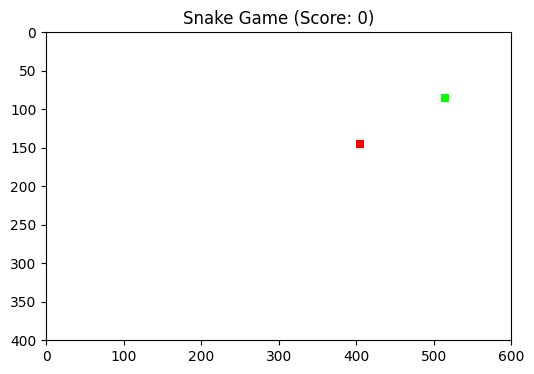

Matplotlib figure closed.
Simulation finished.


In [5]:
# Instantiate the environment
env = SnakeEnv()

# Reset the environment and get initial observation
initial_observation = env.reset()
print(f"Initial Observation: {initial_observation}")

# Simulate several game steps
num_steps = 20
print(f"Simulating {num_steps} steps...")

for i in range(num_steps):
    # Choose a random action (0: UP, 1: DOWN, 2: LEFT, 3: RIGHT)
    action = rd.choice([0, 1, 2, 3]) # Use rd from the globally imported random module

    # Take a step in the environment
    observation, reward, done, info = env.step(action);

    # Render the game state
    env.render_matplotlib()

    # Add a short pause for visualization
    plt.pause(0.05)

    # Check if the game is over
    if done:
        print(f"Game Over! Final Score: {env.score}")
        break

# Close the matplotlib plot to clean up resources
if env.fig is not None:
    plt.close(env.fig)
    print("Matplotlib figure closed.")

print("Simulation finished.")

### Test QLearning

Episode 0: Total Reward = -19.99999999999998, Epsilon = 1.00
Episode 500: Total Reward = -27.199999999999974, Epsilon = 0.50
Episode 1000: Total Reward = -3.6999999999999478, Epsilon = 0.10
Episode 1500: Total Reward = -17.29999999999999, Epsilon = 0.10
Episode 2000: Total Reward = -8.400000000000043, Epsilon = 0.10
Episode 2500: Total Reward = -5.399999999999995, Epsilon = 0.10
Episode 3000: Total Reward = -4.7999999999999705, Epsilon = 0.10
Episode 3500: Total Reward = 8.899999999999814, Epsilon = 0.10
Episode 4000: Total Reward = -12.5, Epsilon = 0.10
Episode 4500: Total Reward = 10.39999999999975, Epsilon = 0.10


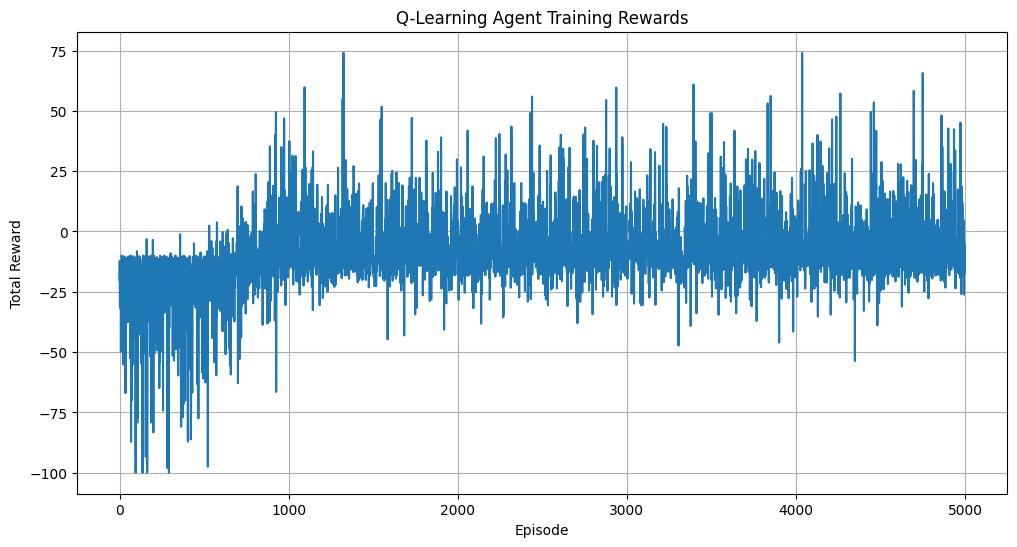

Q-Learning training finished.


In [6]:
num_episodes = 5000
max_steps_per_episode = 1000

Qagent = QLearningAgent(env=SnakeEnv())

rewards_per_episode = []

for episode in range(num_episodes):
    observation = Qagent.env.reset()
    state = Qagent._get_discrete_state(observation)
    done = False
    current_episode_reward = 0

    for step in range(max_steps_per_episode):
        action = Qagent.choose_action(state)
        next_observation, reward, done, info = Qagent.env.step(action)
        next_state = Qagent._get_discrete_state(next_observation)

        Qagent.learn(state, action, reward, next_state)
        state = next_state
        current_episode_reward += reward

        if done:
            break

    Qagent.decay_epsilon()
    rewards_per_episode.append(current_episode_reward)

    if episode % 500 == 0:
        print(f"Episode {episode}: Total Reward = {current_episode_reward}, Epsilon = {Qagent.epsilon:.2f}")

# Plotting rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Agent Training Rewards')
plt.grid(True)
plt.show()

print("Q-Learning training finished.")

Démarrage de la Grid Search (48 combinaisons)...
Params: {'learning_rate': 0.0001, 'discount_factor': 0.75, 'epsilon_decay_rate': 1e-05} -> Score Moyen: 0.11
Params: {'learning_rate': 0.0001, 'discount_factor': 0.75, 'epsilon_decay_rate': 0.0001} -> Score Moyen: 0.40
Params: {'learning_rate': 0.0001, 'discount_factor': 0.75, 'epsilon_decay_rate': 0.001} -> Score Moyen: 6.04
Params: {'learning_rate': 0.0001, 'discount_factor': 0.85, 'epsilon_decay_rate': 1e-05} -> Score Moyen: 0.08
Params: {'learning_rate': 0.0001, 'discount_factor': 0.85, 'epsilon_decay_rate': 0.0001} -> Score Moyen: 0.51
Params: {'learning_rate': 0.0001, 'discount_factor': 0.85, 'epsilon_decay_rate': 0.001} -> Score Moyen: 7.57
Params: {'learning_rate': 0.0001, 'discount_factor': 0.95, 'epsilon_decay_rate': 1e-05} -> Score Moyen: 0.05
Params: {'learning_rate': 0.0001, 'discount_factor': 0.95, 'epsilon_decay_rate': 0.0001} -> Score Moyen: 0.33
Params: {'learning_rate': 0.0001, 'discount_factor': 0.95, 'epsilon_decay_ra

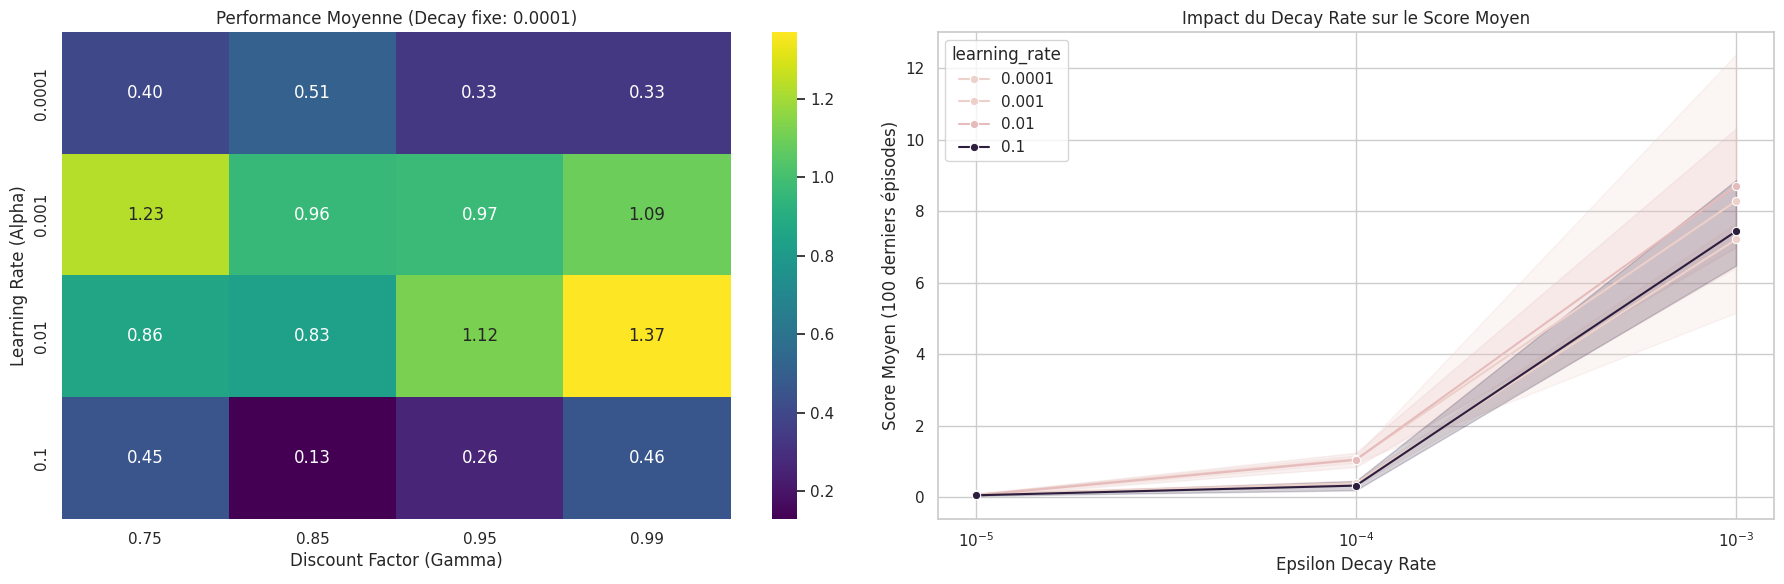


--- MEILLEURE CONFIGURATION ---
learning_rate          0.001
discount_factor        0.990
epsilon_decay_rate     0.001
avg_score             14.180
max_score             60.000
Name: 23, dtype: float64


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

# --- Configuration de la Grid Search ---
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'discount_factor': [0.75, 0.85, 0.95, 0.99],
    'epsilon_decay_rate': [0.00001, 0.0001, 0.001]
}

N_EPISODES = 5000  # Nombre d'épisodes par configuration

results = []

print(f"Démarrage de la Grid Search ({len(list(itertools.product(*param_grid.values())))} combinaisons)...")
start_time = time.time()

# --- Boucle d'entraînement ---
keys, values = zip(*param_grid.items())
for params in itertools.product(*values):
    current_params = dict(zip(keys, params))

    # Instanciation
    env = SnakeEnv()
    agent = QLearningAgent(
        env,
        learning_rate=current_params['learning_rate'],
        discount_factor=current_params['discount_factor'],
        epsilon_decay_rate=current_params['epsilon_decay_rate'],
        epsilon=1.0,
        min_epsilon=0.01
    )

    scores = []

    # Entraînement rapide (sans rendu graphique)
    for episode in range(N_EPISODES):
        obs = env.reset()
        state = agent._get_discrete_state(obs)
        done = False

        while not done:
            action = agent.choose_action(state)
            next_obs, reward, done, _ = env.step(action)
            next_state = agent._get_discrete_state(next_obs)
            agent.learn(state, action, reward, next_state)
            state = next_state

        agent.decay_epsilon()
        scores.append(env.score)

    # Métriques de performance (Moyenne des 100 derniers épisodes)
    avg_score_last_100 = np.mean(scores[-100:])
    max_score = np.max(scores)

    # Stockage des résultats
    result_entry = current_params.copy()
    result_entry['avg_score'] = avg_score_last_100
    result_entry['max_score'] = max_score
    results.append(result_entry)

    print(f"Params: {current_params} -> Score Moyen: {avg_score_last_100:.2f}")

print(f"Terminé en {time.time() - start_time:.2f} secondes.")

# --- Conversion en DataFrame ---
df_results = pd.DataFrame(results)

# --- Visualisations ---

# Configuration du style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 6))

# 1. Heatmap : Learning Rate vs Discount Factor (pour un Decay moyen)
median_decay = param_grid['epsilon_decay_rate'][1]
subset = df_results[df_results['epsilon_decay_rate'] == median_decay]
pivot_table = subset.pivot(index='learning_rate', columns='discount_factor', values='avg_score')

plt.subplot(1, 2, 1)
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f")
plt.title(f'Performance Moyenne (Decay fixe: {median_decay})')
plt.xlabel('Discount Factor (Gamma)')
plt.ylabel('Learning Rate (Alpha)')

# 2. Lineplot : Impact du Decay Rate sur le score global
plt.subplot(1, 2, 2)
sns.lineplot(data=df_results, x='epsilon_decay_rate', y='avg_score', hue='learning_rate', marker='o')
plt.title("Impact du Decay Rate sur le Score Moyen")
plt.xlabel('Epsilon Decay Rate')
plt.ylabel('Score Moyen (100 derniers épisodes)')
plt.xscale('log')

plt.tight_layout()
plt.show()

# --- Meilleur Agent ---
best_run = df_results.loc[df_results['avg_score'].idxmax()]
print("\n--- MEILLEURE CONFIGURATION ---")
print(best_run)

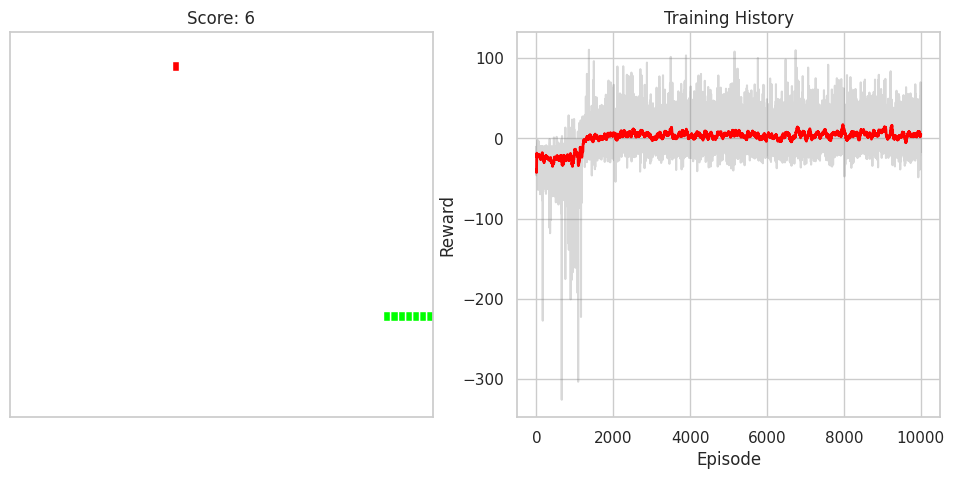

In [8]:
def train_agent_for_dashboard(env, params, n_episodes=1000):
    print(f"--- Entraînement en cours ({n_episodes} épisodes)... ---")

    agent = QLearningAgent(
        env,
        learning_rate=params.get('learning_rate', 0.1),
        discount_factor=params.get('discount_factor', 0.95),
        epsilon_decay_rate=params.get('epsilon_decay_rate', 0.001)
    )

    rewards = []
    moving_avg = []

    for episode in range(n_episodes):
        obs = env.reset()
        state = agent._get_discrete_state(obs)
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_obs, reward, done, _ = env.step(action)
            next_state = agent._get_discrete_state(next_obs)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        rewards.append(total_reward)

        # Calcul moyenne glissante
        window = 50
        current_avg = np.mean(rewards[-window:]) if len(rewards) >= window else np.mean(rewards)
        moving_avg.append(current_avg)

    print("Entraînement terminé.")
    return agent, rewards, moving_avg

def play_with_dashboard(agent, env, rewards, moving_avg):
    fig, (ax_game, ax_stats) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    obs = env.reset()
    state = agent._get_discrete_state(obs)
    done = False
    agent.epsilon = 0

    try:
        while not done:
            action = agent.choose_action(state)
            obs, reward, done, _ = env.step(action)
            state = agent._get_discrete_state(obs)

            ax_game.clear()
            ax_stats.clear()

            ax_game.set_title(f'Score: {env.score}')
            ax_game.set_xlim(0, env.GRID_WIDTH * env.VISUAL_TILE_SIZE)
            ax_game.set_ylim(env.GRID_HEIGHT * env.VISUAL_TILE_SIZE, 0)
            ax_game.set_xticks([]); ax_game.set_yticks([])

            ax_game.add_patch(patches.Rectangle(
                (env.apple_position[0]*env.VISUAL_TILE_SIZE, env.apple_position[1]*env.VISUAL_TILE_SIZE),
                env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE, facecolor='red'
            ))
            for seg in env.snake:
                ax_game.add_patch(patches.Rectangle(
                    (seg[0]*env.VISUAL_TILE_SIZE, seg[1]*env.VISUAL_TILE_SIZE),
                    env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE, facecolor='lime'
                ))

            ax_stats.set_title("Training History")
            ax_stats.plot(rewards, color='gray', alpha=0.3)
            ax_stats.plot(moving_avg, color='red', linewidth=2)
            ax_stats.set_xlabel("Episode")
            ax_stats.set_ylabel("Reward")
            ax_stats.grid(True)

            display.clear_output(wait=True)
            display.display(fig)
            time.sleep(0.05)

    except KeyboardInterrupt:
        pass
    finally:
        plt.close(fig)

params = best_run

env = SnakeEnv()

agent, episode_rewards, moving_averages = train_agent_for_dashboard(env, params, n_episodes=10000)

play_with_dashboard(agent, env, episode_rewards, moving_averages)

### Test REINFORCE

Démarrage de l'entraînement REINFORCE (50000 épisodes)...
Episode 0 | Reward Moy: -13.20 | Score Moy: 0.00
Episode 100 | Reward Moy: -13.97 | Score Moy: 0.01
Episode 200 | Reward Moy: -14.33 | Score Moy: 0.01
Episode 300 | Reward Moy: -12.78 | Score Moy: 0.05
Episode 400 | Reward Moy: -13.06 | Score Moy: 0.02
Episode 500 | Reward Moy: -12.41 | Score Moy: 0.02
Episode 600 | Reward Moy: -11.82 | Score Moy: 0.03
Episode 700 | Reward Moy: -13.47 | Score Moy: 0.02
Episode 800 | Reward Moy: -13.78 | Score Moy: 0.02
Episode 900 | Reward Moy: -14.11 | Score Moy: 0.03
Episode 1000 | Reward Moy: -13.88 | Score Moy: 0.02
Episode 1100 | Reward Moy: -14.14 | Score Moy: 0.03
Episode 1200 | Reward Moy: -13.88 | Score Moy: 0.04
Episode 1300 | Reward Moy: -13.92 | Score Moy: 0.00
Episode 1400 | Reward Moy: -12.84 | Score Moy: 0.02
Episode 1500 | Reward Moy: -13.02 | Score Moy: 0.01
Episode 1600 | Reward Moy: -13.14 | Score Moy: 0.02
Episode 1700 | Reward Moy: -13.12 | Score Moy: 0.01
Episode 1800 | Rew

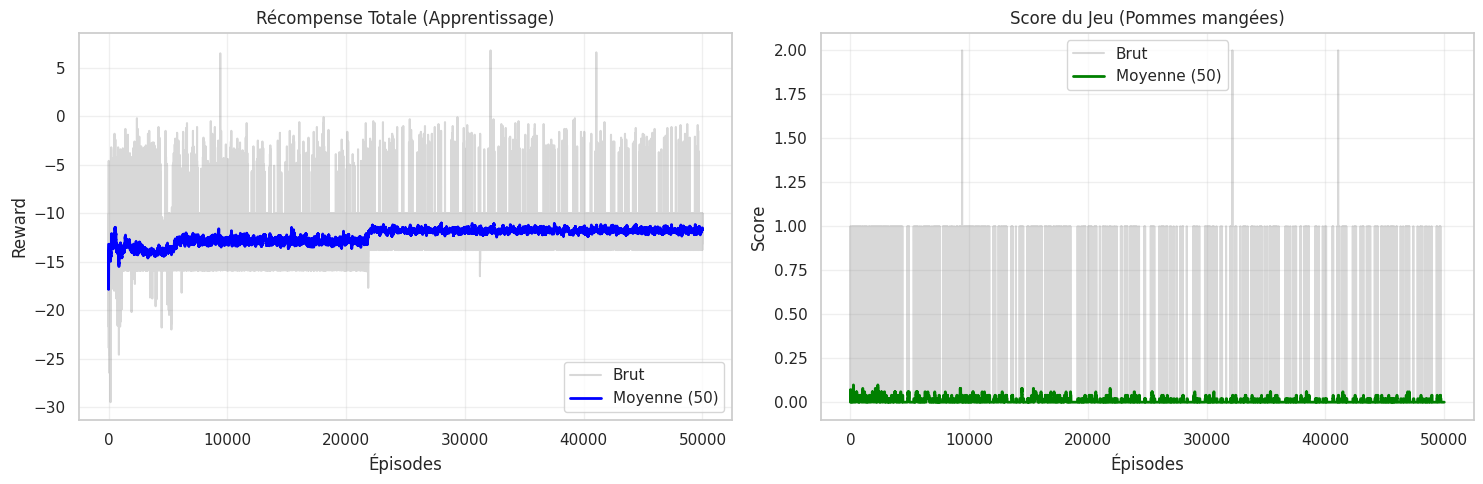

Max Score atteint : 2


In [9]:
# Paramètres
num_episodes_reinforce = 50000
max_steps_per_episode_reinforce = 1000
window_size = 50

# Instanciation
reinforce_agent = ReinforceAgent(env=SnakeEnv())

# Listes pour le stockage
rewards_history = []
scores_history = []

print(f"Démarrage de l'entraînement REINFORCE ({num_episodes_reinforce} épisodes)...")

for episode in range(num_episodes_reinforce):
    observation = reinforce_agent.env.reset()
    done = False
    current_episode_reward = 0

    for step in range(max_steps_per_episode_reinforce):
        # 1. Action
        action = reinforce_agent.choose_action(observation)

        # 2. Step
        next_observation, reward, done, info = reinforce_agent.env.step(action)

        # 3. Stockage
        reinforce_agent.store_transition(reward)

        observation = next_observation
        current_episode_reward += reward

        if done:
            break

    # 4. Apprentissage
    reinforce_agent.learn()

    # 5. Enregistrement des métriques
    rewards_history.append(current_episode_reward)
    scores_history.append(reinforce_agent.env.score) # On récupère le score final du jeu

    # Logging console
    if episode % 100 == 0:
        avg_rew = np.mean(rewards_history[-100:]) if len(rewards_history) > 0 else current_episode_reward
        avg_score = np.mean(scores_history[-100:]) if len(scores_history) > 0 else reinforce_agent.env.score
        print(f"Episode {episode} | Reward Moy: {avg_rew:.2f} | Score Moy: {avg_score:.2f}")

# --- Calcul des moyennes glissantes ---
def get_moving_average(data, window):
    return [np.mean(data[max(0, i-window):i+1]) for i in range(len(data))]

ma_rewards = get_moving_average(rewards_history, window_size)
ma_scores = get_moving_average(scores_history, window_size)

# --- Visualisation ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1 : Récompenses (Apprentissage)
ax1.plot(rewards_history, label='Brut', color='gray', alpha=0.3)
ax1.plot(ma_rewards, label=f'Moyenne ({window_size})', color='blue', linewidth=2)
ax1.set_title('Récompense Totale (Apprentissage)')
ax1.set_xlabel('Épisodes')
ax1.set_ylabel('Reward')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2 : Scores (Performance Jeu)
ax2.plot(scores_history, label='Brut', color='gray', alpha=0.3)
ax2.plot(ma_scores, label=f'Moyenne ({window_size})', color='green', linewidth=2)
ax2.set_title('Score du Jeu (Pommes mangées)')
ax2.set_xlabel('Épisodes')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max Score atteint : {max(scores_history)}")

Démarrage du Grid Search (9 combinaisons)...
Test config: LR=0.0005, Gamma=0.9 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.0005, Gamma=0.95 ...
 -> Score Final Moyen: 0.08
Test config: LR=0.0005, Gamma=0.99 ...
 -> Score Final Moyen: 0.04
Test config: LR=0.001, Gamma=0.9 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.001, Gamma=0.95 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.001, Gamma=0.99 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.005, Gamma=0.9 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.005, Gamma=0.95 ...
 -> Score Final Moyen: 0.00
Test config: LR=0.005, Gamma=0.99 ...
 -> Score Final Moyen: 0.02


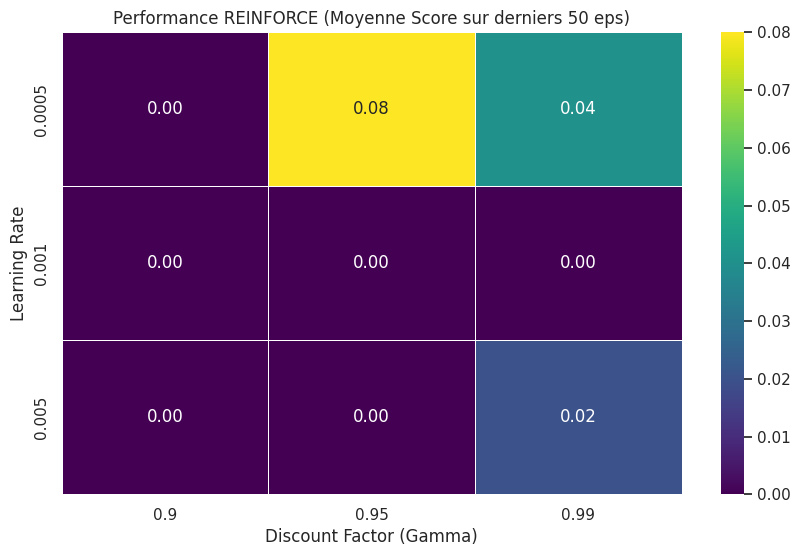


--- MEILLEURE CONFIGURATION ---
learning_rate      0.0005
discount_factor    0.9500
avg_score          0.0800
Name: 1, dtype: float64


In [11]:
# Configuration de la Grid Search
param_grid = {
    'learning_rate': [0.0005, 0.001, 0.005], # Sensibilité forte
    'discount_factor': [0.90, 0.95, 0.99]    # Vision long terme
}

EPISODES_PER_RUN = 500
MAX_STEPS = 500 # Limite pour éviter les boucles infinies au début

results = []

print(f"Démarrage du Grid Search ({len(list(itertools.product(*param_grid.values())))} combinaisons)...")

# Boucle de Recherche
keys, values = zip(*param_grid.items())

for params in itertools.product(*values):
    current_params = dict(zip(keys, params))
    lr = current_params['learning_rate']
    gamma = current_params['discount_factor']

    print(f"Test config: LR={lr}, Gamma={gamma} ...")

    # Instanciation d'un nouvel agent et env pour chaque test
    env = SnakeEnv()
    agent = ReinforceAgent(env, learning_rate=lr, discount_factor=gamma)

    scores = []

    for episode in range(EPISODES_PER_RUN):
        obs = env.reset()
        done = False

        for step in range(MAX_STEPS):
            action = agent.choose_action(obs)
            next_obs, reward, done, _ = env.step(action)
            agent.store_transition(reward)
            obs = next_obs
            if done:
                break

        agent.learn()
        scores.append(env.score)

    # Métrique : Score moyen sur les 50 derniers épisodes (Stabilité finale)
    final_avg_score = np.mean(scores[-50:])

    res = current_params.copy()
    res['avg_score'] = final_avg_score
    results.append(res)

    print(f" -> Score Final Moyen: {final_avg_score:.2f}")

# Traitement des résultats
df_results = pd.DataFrame(results)

# Visualisation (Heatmap)
pivot_table = df_results.pivot(index='learning_rate', columns='discount_factor', values='avg_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title(f'Performance REINFORCE (Moyenne Score sur derniers 50 eps)')
plt.ylabel('Learning Rate')
plt.xlabel('Discount Factor (Gamma)')
plt.show()

# Meilleur Agent
best_idx = df_results['avg_score'].idxmax()
best_config = df_results.iloc[best_idx]
print("\n--- MEILLEURE CONFIGURATION ---")
print(best_config)

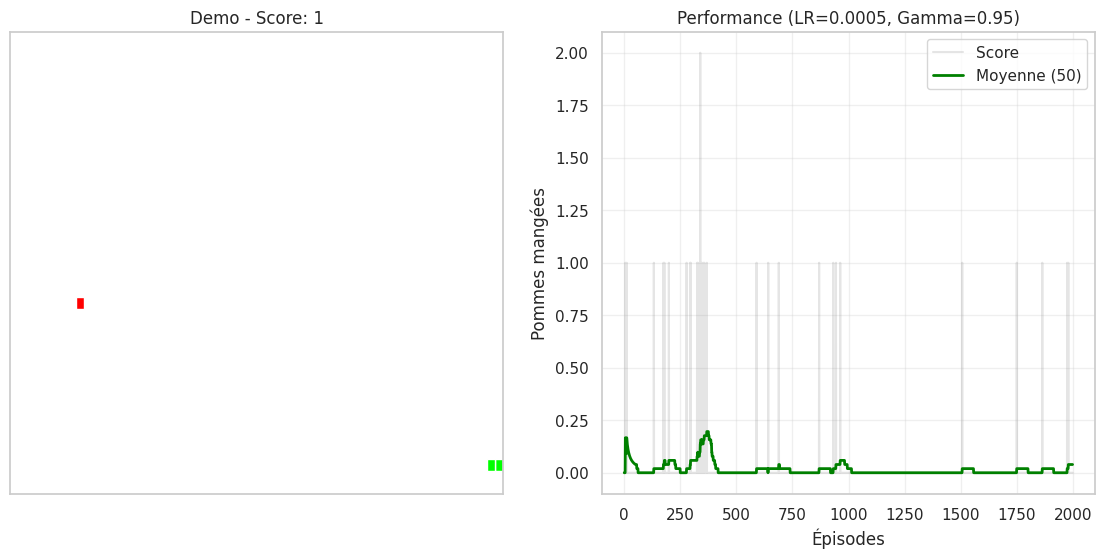

Fin de la démo. Score : 1


In [12]:
# Récupération des hyperparamètres depuis best_config
if 'best_config' in locals():
    best_lr = best_config['learning_rate']
    best_gamma = best_config['discount_factor']
    print(f"--- Configuration Optimale chargée ---")
    print(f"Learning Rate : {best_lr}")
    print(f"Discount Factor : {best_gamma}")
else:
    best_lr = 0.001
    best_gamma = 0.99
    print("Attention : 'best_config' introuvable. Utilisation des valeurs par défaut.")

# Paramètres de l'entraînement
N_EPISODES_FULL = 2000
MAX_STEPS = 2000

# Initialisation de l'agent optimisé
env = SnakeEnv()
agent = ReinforceAgent(env, learning_rate=best_lr, discount_factor=best_gamma)

rewards_history = []
scores_history = []

print(f"Démarrage de l'entraînement final ({N_EPISODES_FULL} épisodes)...")

# Boucle d'entraînement
for episode in range(N_EPISODES_FULL):
    obs = env.reset()
    done = False
    ep_reward = 0

    for step in range(MAX_STEPS):
        action = agent.choose_action(obs)
        next_obs, reward, done, _ = env.step(action)

        agent.store_transition(reward)
        obs = next_obs
        ep_reward += reward

        if done:
            break

    agent.learn()

    rewards_history.append(ep_reward)
    scores_history.append(env.score)

    if episode % 100 == 0:
        avg_score = np.mean(scores_history[-100:])
        print(f"Episode {episode} | Score Moyen (100 derniers) : {avg_score:.2f}")

print("Entraînement terminé.")

# Visualisation

# Moyenne glissante pour les courbes
window = 50
ma_scores = [np.mean(scores_history[max(0, i-window):i+1]) for i in range(len(scores_history))]

fig, (ax_game, ax_stats) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

obs = env.reset()
done = False

print("Lancement de la démonstration...")

try:
    while not done:
        # L'agent joue
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)

        # Nettoyage
        ax_game.clear()
        ax_stats.clear()

        # JEU (Gauche)
        ax_game.set_title(f'Demo - Score: {env.score}')
        ax_game.set_xlim(0, env.GRID_WIDTH * env.VISUAL_TILE_SIZE)
        ax_game.set_ylim(env.GRID_HEIGHT * env.VISUAL_TILE_SIZE, 0)
        ax_game.set_xticks([])
        ax_game.set_yticks([])

        # Pomme
        ax_game.add_patch(patches.Rectangle(
            (env.apple_position[0]*env.VISUAL_TILE_SIZE, env.apple_position[1]*env.VISUAL_TILE_SIZE),
            env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE, facecolor='red'
        ))
        # Snake
        for seg in env.snake:
            ax_game.add_patch(patches.Rectangle(
                (seg[0]*env.VISUAL_TILE_SIZE, seg[1]*env.VISUAL_TILE_SIZE),
                env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE, facecolor='lime'
            ))

        # STATS (Droite)
        ax_stats.set_title(f"Performance (LR={best_lr}, Gamma={best_gamma})")
        ax_stats.plot(scores_history, color='gray', alpha=0.2, label='Score')
        ax_stats.plot(ma_scores, color='green', linewidth=2, label=f'Moyenne ({window})')
        ax_stats.set_xlabel("Épisodes")
        ax_stats.set_ylabel("Pommes mangées")
        ax_stats.legend()
        ax_stats.grid(True, alpha=0.3)

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.05)

    print(f"Fin de la démo. Score : {env.score}")

except KeyboardInterrupt:
    print("Arrêt manuel.")
finally:
    plt.close(fig)

### Test PPO Agent 

Démarrage PPO sur cpu...
Episode 0 	 Score Moyen: 0.00 	 Timestep: 68
Episode 50 	 Score Moyen: 0.06 	 Timestep: 3102
Episode 100 	 Score Moyen: 0.02 	 Timestep: 6831
Episode 150 	 Score Moyen: 0.00 	 Timestep: 15365
Episode 200 	 Score Moyen: 0.24 	 Timestep: 37707
Episode 250 	 Score Moyen: 0.58 	 Timestep: 67239
Episode 300 	 Score Moyen: 0.38 	 Timestep: 90887
Episode 350 	 Score Moyen: 0.72 	 Timestep: 115088
Episode 400 	 Score Moyen: 0.90 	 Timestep: 144132
Episode 450 	 Score Moyen: 0.58 	 Timestep: 167764
Episode 500 	 Score Moyen: 0.56 	 Timestep: 187980
Episode 550 	 Score Moyen: 1.02 	 Timestep: 209967
Episode 600 	 Score Moyen: 1.16 	 Timestep: 228698
Episode 650 	 Score Moyen: 1.52 	 Timestep: 247959
Episode 700 	 Score Moyen: 0.78 	 Timestep: 262922
Episode 750 	 Score Moyen: 1.44 	 Timestep: 281409
Episode 800 	 Score Moyen: 1.18 	 Timestep: 295630
Episode 850 	 Score Moyen: 1.00 	 Timestep: 309067
Episode 900 	 Score Moyen: 1.16 	 Timestep: 324489
Episode 950 	 Score M

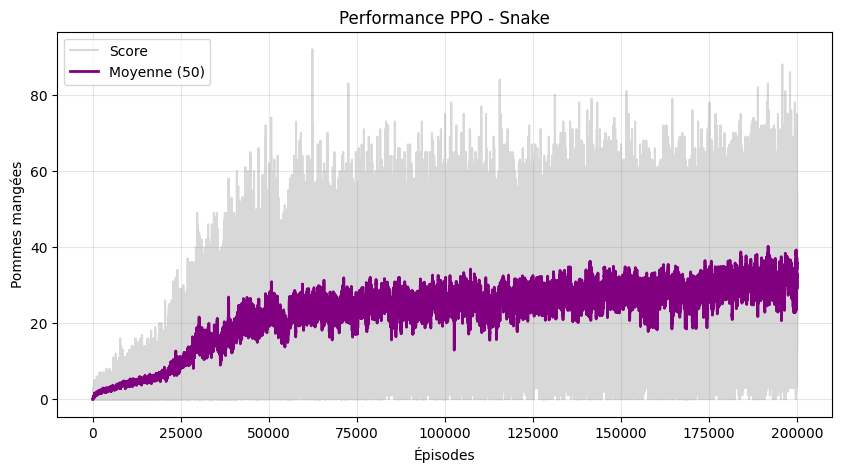

In [6]:
def train_ppo(env_class, max_episodes=2000, update_timestep=2000):
    env = env_class()

    state_dim = 11  # Taille vecteur observation Snake
    action_dim = 4  # UP, DOWN, LEFT, RIGHT

    agent = PPOAgent(state_dim, action_dim, lr=0.0003, gamma=0.99, k_epochs=4)

    time_step = 0
    scores_history = []

    print(f"Démarrage PPO sur {device}...")

    for episode in range(max_episodes):
        state = env.reset()
        current_ep_reward = 0
        done = False

        # Pour reward shaping
        prev_dist = math.sqrt((state[0]*env.GRID_WIDTH - state[2]*env.GRID_WIDTH)**2 +
                              (state[1]*env.GRID_HEIGHT - state[3]*env.GRID_HEIGHT)**2)

        while not done:
            time_step += 1

            # 1. Action
            action, log_prob = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)

            # 2. Reward Shaping (Critique pour Snake + PPO)
            dist = math.sqrt((env.snake[0][0] - env.apple_position[0])**2 +
                             (env.snake[0][1] - env.apple_position[1])**2)

            if reward == 10:
                reward = 10
            elif reward == -10:
                reward = -10
            else:
                # Incitation au mouvement vers la pomme
                if dist < prev_dist:
                    reward = 0.1
                else:
                    reward = -0.15

            prev_dist = dist

            # 3. Stockage
            agent.store_transition(state, action, log_prob, reward, done)

            state = next_state
            current_ep_reward += reward

            # 4. Update PPO
            if time_step % update_timestep == 0:
                agent.update()

        scores_history.append(env.score)

        if episode % 50 == 0:
            avg_score = np.mean(scores_history[-50:])
            print(f"Episode {episode} \t Score Moyen: {avg_score:.2f} \t Timestep: {time_step}")

    return agent, scores_history

def plot_ppo_results(scores):
    window = 50
    ma_scores = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]

    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Score', alpha=0.3, color='gray')
    plt.plot(ma_scores, label='Moyenne (50)', color='purple', linewidth=2)
    plt.title('Performance PPO - Snake')
    plt.xlabel('Épisodes')
    plt.ylabel('Pommes mangées')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Lancer l'entraînement
agent_ppo, scores_ppo = train_ppo(SnakeEnv, max_episodes=200000)
plot_ppo_results(scores_ppo)

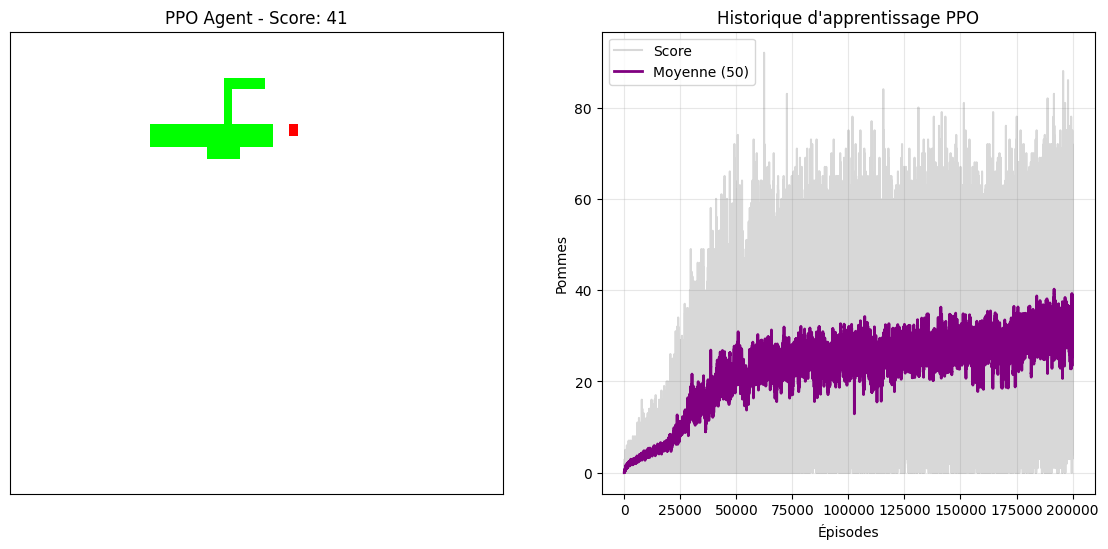

Visualisation terminée. Score final : 41


In [7]:
def watch_ppo_agent(agent, env_class, scores_history=None):
    """
    Visualise une partie complète de l'agent PPO.
    Args:
        agent: L'instance de PPOAgent entraînée.
        env_class: La classe de l'environnement (ex: SnakeEnv).
        scores_history: Liste des scores obtenue pendant l'entraînement.
    """
    env = env_class()
    state = env.reset()
    done = False

    agent.actor.eval()

    # Configuration de la figure
    fig, (ax_game, ax_stats) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

    print("Démarrage de la visualisation PPO...")

    try:
        while not done:
            # 1. Choix de l'action (PPO retourne action, log_prob)
            # On ignore log_prob ici
            action, _ = agent.choose_action(state)

            # 2. Exécution
            state, reward, done, _ = env.step(action)

            # --- RENDU GRAPHIQUE ---

            # A. Nettoyage
            ax_game.clear()
            ax_stats.clear()

            # B. Jeu (Gauche)
            ax_game.set_title(f'PPO Agent - Score: {env.score}')
            ax_game.set_xlim(0, env.GRID_WIDTH * env.VISUAL_TILE_SIZE)
            ax_game.set_ylim(env.GRID_HEIGHT * env.VISUAL_TILE_SIZE, 0) # Inversion Y
            ax_game.set_xticks([])
            ax_game.set_yticks([])

            # Dessin de la pomme
            apple_rect = patches.Rectangle(
                (env.apple_position[0] * env.VISUAL_TILE_SIZE, env.apple_position[1] * env.VISUAL_TILE_SIZE),
                env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE,
                facecolor='red'
            )
            ax_game.add_patch(apple_rect)

            # Dessin du serpent
            for segment in env.snake:
                snake_rect = patches.Rectangle(
                    (segment[0] * env.VISUAL_TILE_SIZE, segment[1] * env.VISUAL_TILE_SIZE),
                    env.VISUAL_TILE_SIZE, env.VISUAL_TILE_SIZE,
                    facecolor='lime' # Vert fluo pour PPO
                )
                ax_game.add_patch(snake_rect)

            # C. Statistiques (Droite)
            if scores_history:
                ax_stats.set_title("Historique d'apprentissage PPO")
                ax_stats.plot(scores_history, color='gray', alpha=0.3, label='Score')

                # Moyenne glissante
                if len(scores_history) >= 50:
                    window = 50
                    ma = [np.mean(scores_history[max(0, i-window):i+1]) for i in range(len(scores_history))]
                    ax_stats.plot(ma, color='purple', linewidth=2, label='Moyenne (50)')

                ax_stats.set_xlabel("Épisodes")
                ax_stats.set_ylabel("Pommes")
                ax_stats.legend()
                ax_stats.grid(True, alpha=0.3)
            else:
                ax_stats.text(0.5, 0.5, "Pas d'historique fourni", ha='center')

            # D. Mise à jour affichage
            display.clear_output(wait=True)
            display.display(fig)

            # Vitesse de jeu (0.05s = rapide, 0.1s = normal)
            time.sleep(0.05)

        print(f"Visualisation terminée. Score final : {env.score}")

    except KeyboardInterrupt:
        print("Arrêt manuel par l'utilisateur.")
    finally:
        # Remise en mode train
        agent.actor.train()
        plt.close(fig)

if 'agent_ppo' in locals() and 'scores_ppo' in locals():
    watch_ppo_agent(agent_ppo, SnakeEnv, scores_ppo)
else:
    print("Erreur : Veuillez d'abord entraîner l'agent (fonction train_ppo).")

## __Observations sur les résulats__

Nos expérimentations révèlent une supériorité notable de l'agent Q-Learning qui, grâce à une simplification efficace de l'environnement, atteint rapidement un score moyen de 15 en 5 000 épisodes. Cette performance contraste fortement avec la lenteur de convergence observée chez les agents de type Policy Gradient. En effet, même après 20 000 épisodes, l'algorithme PPO ne parvient qu'à un score moyen de 6, soulignant le coût élevé de l'apprentissage profond en termes de volume de données nécessaire. De plus, l'incapacité de l'agent REINFORCE à franchir la barre d'un score moyen de 1 corrobore les limitations théoriques de cet algorithme, notamment sa forte variance qui le rend inadapté aux environnements nécessitant une précision séquentielle élevée comme le Snake.